In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

import matplotlib as mpl

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.colors
import numpy as np
import glob
import re 

In [2]:
# imports to write dynamic markdown contents
import os
from IPython.display import display, Markdown, Latex
from IPython.display import HTML

# turn off/on code for the result HTML page

display(Markdown('*For the result HTML page:* '))
    
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

*For the result HTML page:* 

## Input, preprocessing

In [3]:
# file_base = 'data/Fun4All_G4_EICDetector_MaterialScan_'
# file_base = 'data/Fun4All_G4_EICDetector_ECCE_Prop4_A'
# file_base = 'data/Fun4All_G4_EICDetector_ECCE_Prop4_B'
file_base = 'data/Fun4All_G4_EICDetector_ECCE_Prop5_A'

filenames = glob.glob(os.path.join(f'{file_base}*.log'))
print(len(filenames))
filenames.sort();

DataSetLables = {
    1: 'Vacuum',
    2: 'Au-coated beam chamber',
    3: 'Barrel silicon',
    4: 'Barrel muRwell',
    5: 'Forward/backward silicon',
    6: 'Forward/backward MPGD',
    7: 'mRICH AeroGel',
    8: 'Forward AC-LGAD',    
    9: 'Dual RICH',
    10: 'Backward AC-LGAD',
    11: 'Barrel AC-LGAD',
    12: 'Backward EMCal',
    13: 'Inner det. spt./service',
    14: 'DIRC',
    15: 'BCal',
    16: 'Active BCal Support',
    17: 'SC Magnet',
    18: 'Barrel HCal',
    19: 'Backward Field Return',
    20: 'Forward EMCal',
    21: 'Forward LHCal',
};
print('Mapping: ', DataSetLables)

CautiousLabel = 'prop.5, Oct-2021 concept'

mpl.style.use('seaborn-talk')
colors = np.concatenate((pylab.cm.tab20(np.linspace(0,1,21))[0:19],  pylab.cm.tab20b(np.linspace(0,1,21))[0:19]) )

21
Mapping:  {1: 'Vacuum', 2: 'Au-coated beam chamber', 3: 'Barrel silicon', 4: 'Barrel muRwell', 5: 'Forward/backward silicon', 6: 'Forward/backward MPGD', 7: 'mRICH AeroGel', 8: 'Forward AC-LGAD', 9: 'Dual RICH', 10: 'Backward AC-LGAD', 11: 'Barrel AC-LGAD', 12: 'Backward EMCal', 13: 'Inner det. spt./service', 14: 'DIRC', 15: 'BCal', 16: 'Active BCal Support', 17: 'SC Magnet', 18: 'Barrel HCal', 19: 'Backward Field Return', 20: 'Forward EMCal', 21: 'Forward LHCal'}


In [4]:
temp = re.compile("^\s+([-+]?\d*\.?\d*)\s+([-+]?\d*\.?\d*)\s+([-+]?\d*\.?\d*)\s+([-+]?\d*\.?\d*)\s+([-+]?\d*\.?\d*)\s*$") 
Setups = [];
Thetas = [];
Phis = [];
Lengths = [];
x0s = [];
lambda0s = [];

for filename in filenames:
    
    filename_base = os.path.basename(filename)
    
    setupID = int(filename_base.split('.')[0].split('_')[-1]);
    
    if setupID not in DataSetLables.keys() :
        print(f'Skip {setupID}: {filename}')
        continue;
        
    print(f'Reading {setupID}: {filename} ...')

    cnt = 0;
    file1 = open(filename, 'r') 
    Lines = file1.readlines() 
    for line in Lines: 
    #     line = line.strip();  

        match = temp.match(line) 

        if match:
            res = match.groups()
            if (len(res) == 5):

    #             print (line)
    #             print (res)            
                scanData = [float(n) for n in res]

                if (scanData[1]<=360 ):
                    Setups.append(setupID) 
                    Thetas.append(scanData[0]) 
                    Phis.append(scanData[1]) 
                    Lengths.append(scanData[2]) 
                    x0s.append(scanData[3]) 
                    lambda0s.append(scanData[4]) 

                    cnt = cnt +1
                
    print(f'{setupID}: {filename} -> {cnt} records')
    
    


Reading 1: data/Fun4All_G4_EICDetector_ECCE_Prop5_A_1.log ...
1: data/Fun4All_G4_EICDetector_ECCE_Prop5_A_1.log -> 0 records
Reading 10: data/Fun4All_G4_EICDetector_ECCE_Prop5_A_10.log ...
10: data/Fun4All_G4_EICDetector_ECCE_Prop5_A_10.log -> 131519 records
Reading 11: data/Fun4All_G4_EICDetector_ECCE_Prop5_A_11.log ...
11: data/Fun4All_G4_EICDetector_ECCE_Prop5_A_11.log -> 131519 records
Reading 12: data/Fun4All_G4_EICDetector_ECCE_Prop5_A_12.log ...
12: data/Fun4All_G4_EICDetector_ECCE_Prop5_A_12.log -> 131519 records
Reading 13: data/Fun4All_G4_EICDetector_ECCE_Prop5_A_13.log ...
13: data/Fun4All_G4_EICDetector_ECCE_Prop5_A_13.log -> 131519 records
Reading 14: data/Fun4All_G4_EICDetector_ECCE_Prop5_A_14.log ...
14: data/Fun4All_G4_EICDetector_ECCE_Prop5_A_14.log -> 131519 records
Reading 15: data/Fun4All_G4_EICDetector_ECCE_Prop5_A_15.log ...
15: data/Fun4All_G4_EICDetector_ECCE_Prop5_A_15.log -> 131519 records
Reading 16: data/Fun4All_G4_EICDetector_ECCE_Prop5_A_16.log ...
16: dat

In [5]:
df = pd.DataFrame(
    {'Setup':Setups, 
     'Theta':Thetas,
     'Phi': Phis,
     'Length': Lengths,
     'x0':x0s,
     'lambda0':lambda0s,
    });
df.set_index(['Setup','Theta','Phi'], inplace=True)
df.sort_index(level = 2)

df

Length        x0   lambda0
Setup Theta    Phi                                  
10    -88.4453 29.4537   6002.21   5.01742  0.519007
               30.6038   6002.21  19.83630  2.051890
               31.7540   6002.21  32.84240  3.397250
               32.9042   6002.21  44.36160  4.588810
               34.0543   6002.21  54.88670  5.677530
...                          ...       ...       ...
9      88.4453 354.9490  6002.21   3.42539  0.357163
               356.0990  6002.21   3.42157  0.356768
               357.2490  6002.21   3.41706  0.356301
               358.3990  6002.21   3.41569  0.356159
               359.5500  6002.21   3.41637  0.356229

[2630380 rows x 3 columns]

In [6]:
# ave = df.loc[(9,0),:].mean(axis = 0) 

## Radiation length

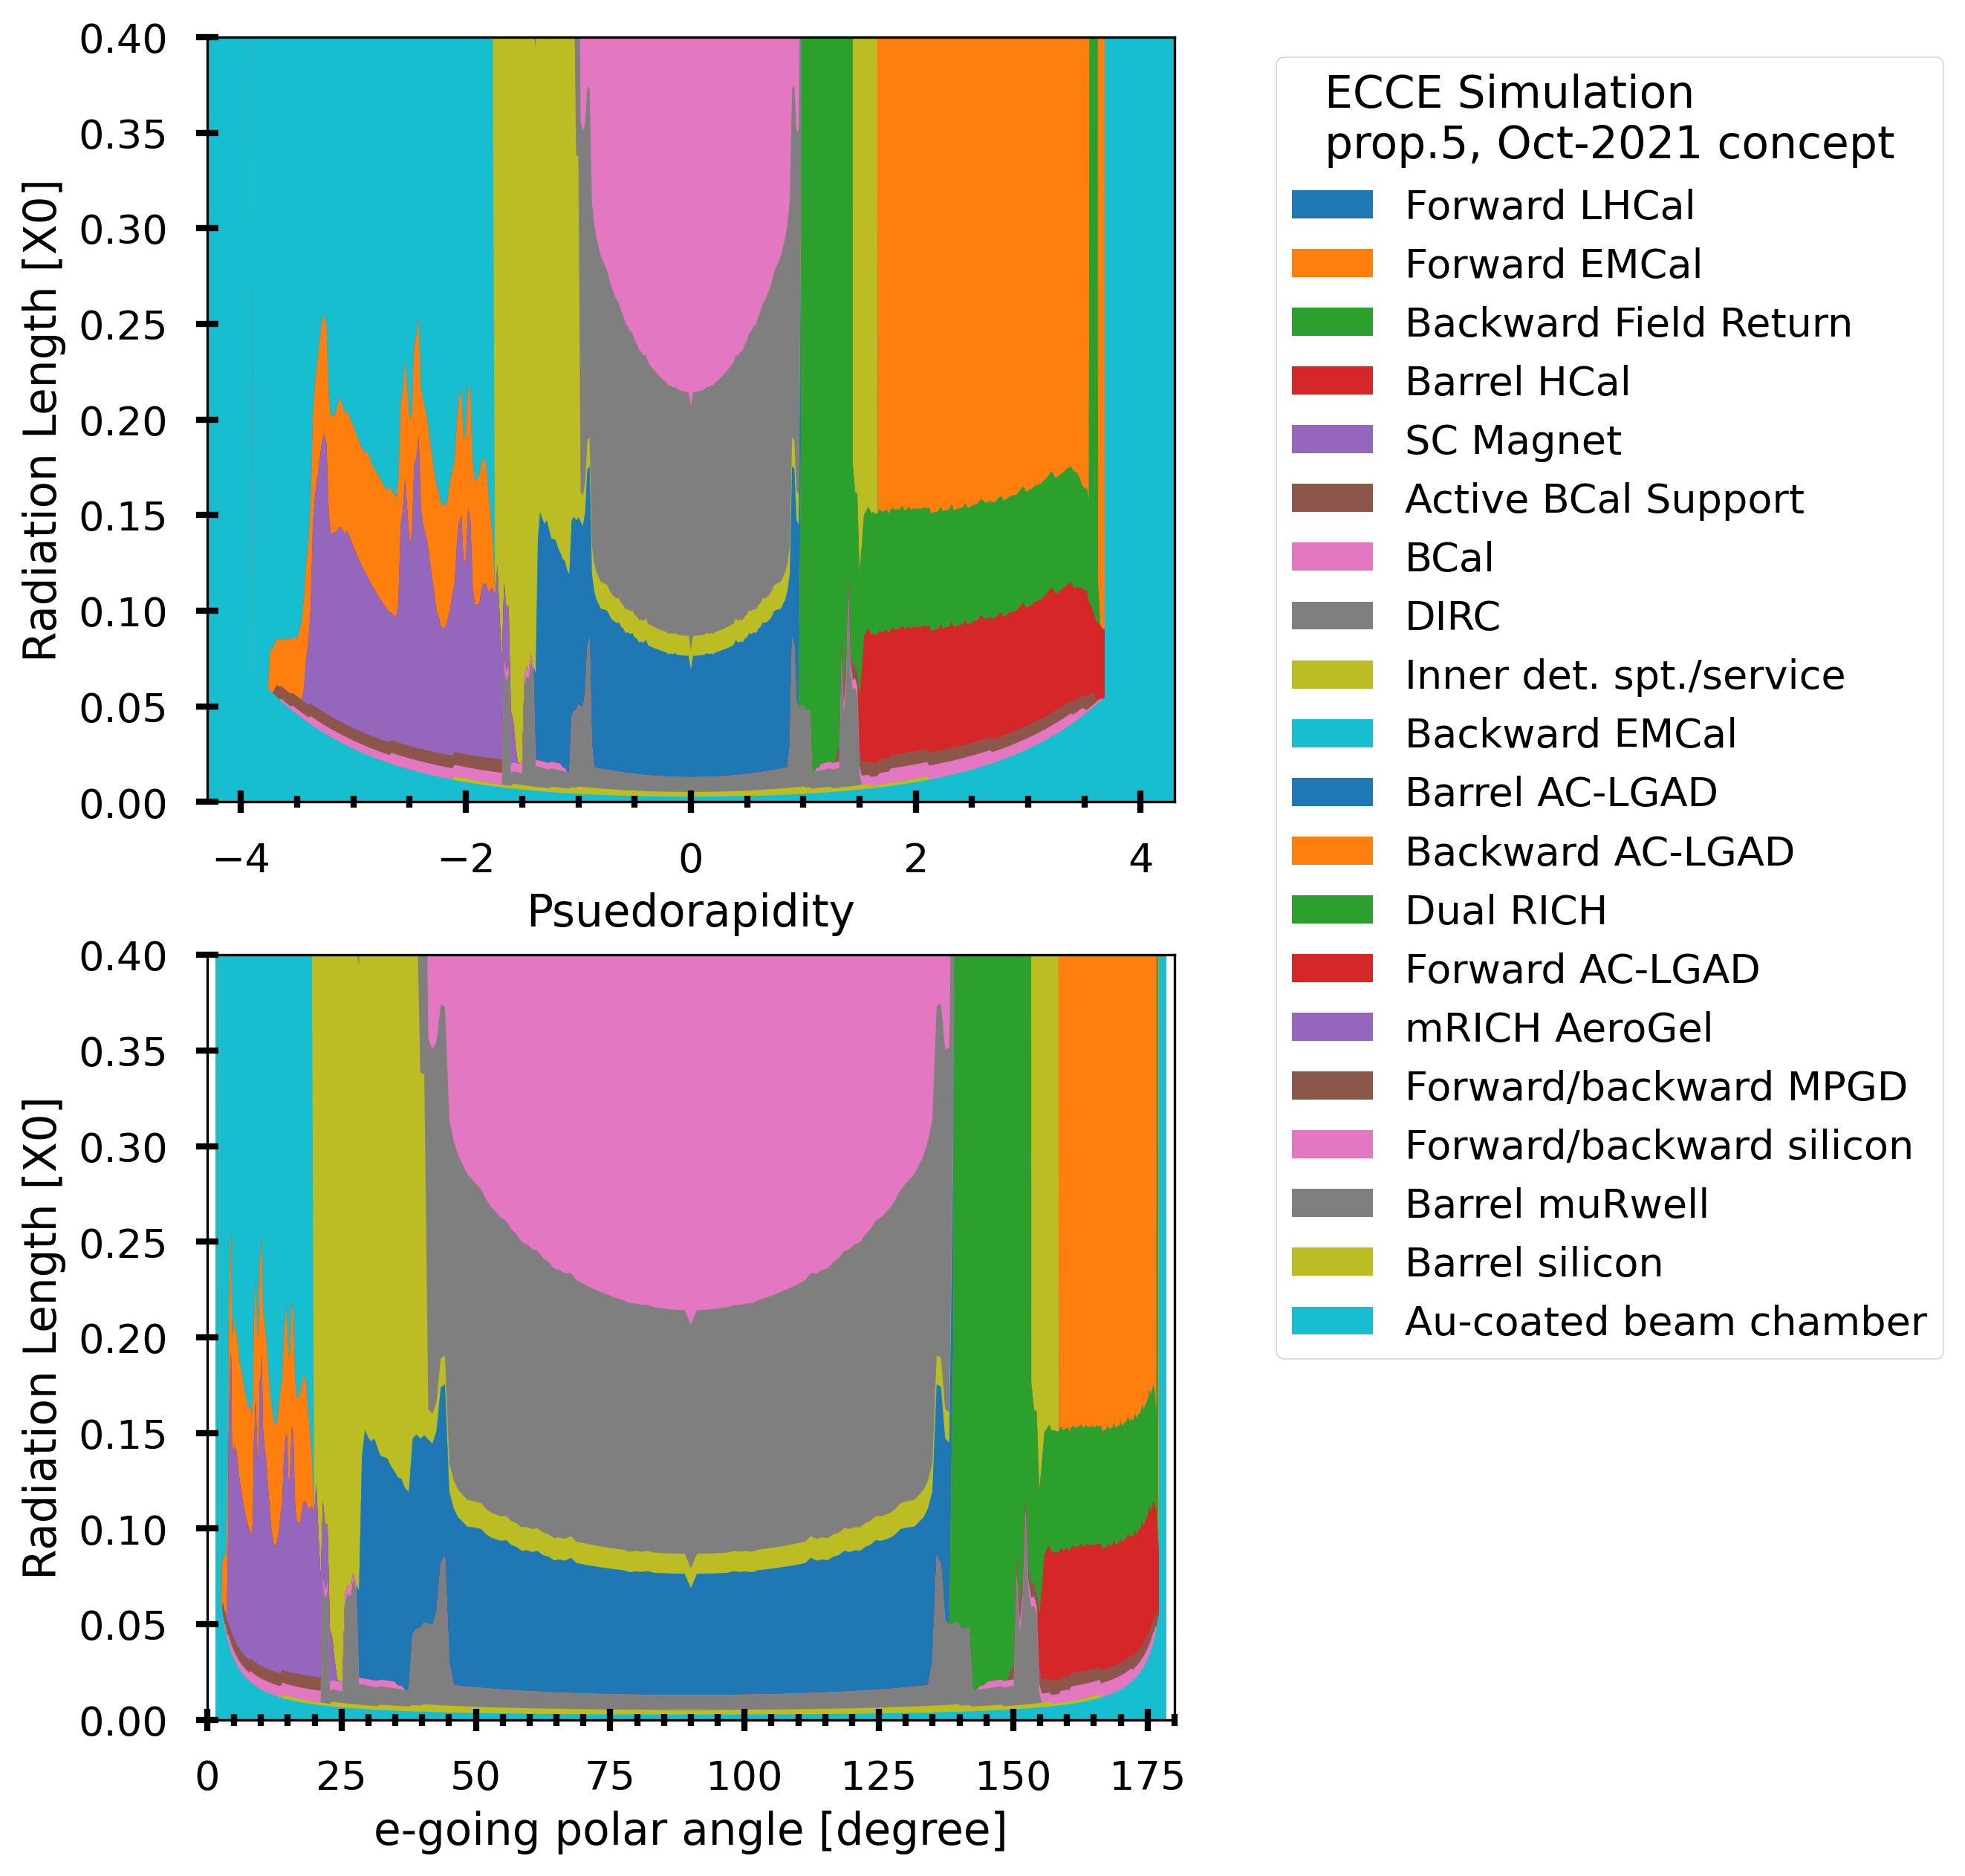

In [7]:
# fig= plt.figure(num=None, figsize=(8, 16), dpi=80, facecolor='w', edgecolor='k')
# ax = fig.add_subplot(1, 1, 1)  # create an axes object in the figure
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 10), dpi=300)



datasets = sorted(df.index.levels[0].unique().to_list(), reverse=True)

for dataset in datasets:
    
    x0_avg = df.loc[(dataset),:].groupby('Theta').x0.mean()
    etas = -np.log(np.tan( ((90-x0_avg.index.to_numpy())/180*np.pi)/2 ))
    polar_angles = 180- ( 90-x0_avg.index.to_numpy() )
    DataSetLable = DataSetLables[dataset]
    
    axs[0].fill_between( etas, 0, x0_avg.to_numpy(), label=DataSetLable)
    
    axs[1].fill_between( polar_angles, 0, x0_avg.to_numpy(), label=DataSetLable)
   

ax=axs[0]
    
# ax.set_title(f'Fun4All-EIC Simulation. Tracking and PID detectors\n{CautiousLabel}')
# ax.set_yscale('log')
ax.set_xlabel("Pseudorapidity")
ax.set_ylabel("Radiation Length [X0]")
ax.set_xlim([-4.3, 4.3]);
ax.set_ylim([0, 0.4]);

ax.tick_params(which='both',direction='inout');
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=7)
ax.tick_params(which='minor', length=4)

chartBox = ax.get_position()
ax.set_position([chartBox.x0, chartBox.y0, chartBox.width*0.7, chartBox.height])
ax.legend(loc='upper center', bbox_to_anchor=(1.45, 1), ncol=1,
         title = f'ECCE Simulation\n{CautiousLabel}',
         title_fontsize='x-large'
         )

ax=axs[1]
    
# ax.set_title('Raditioan Length Scans')
# ax.set_yscale('log')
ax.set_xlabel("e-going polar angle [degree]")
ax.set_ylabel("Radiation Length [X0]")
ax.set_xlim([0, 180]);
ax.set_ylim([0, 0.4]);

ax.tick_params(which='both',direction='inout');
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=7)
ax.tick_params(which='minor', length=4)

chartBox = ax.get_position()
ax.set_position([chartBox.x0, chartBox.y0, chartBox.width*0.7, chartBox.height])
# ax.legend(loc='upper center', bbox_to_anchor=(1.45, 1), ncol=1,
#          title = f'Fun4All-EIC Simulation\nTracking and PID detectors\n{CautiousLabel}',
#          title_fontsize='x-large'
#          )

plt.savefig(os.path.join(f'{file_base}_Raditioan_Length.pdf'), bbox_inches='tight')
plt.savefig(os.path.join(f'{file_base}_Raditioan_Length.png'), bbox_inches='tight')

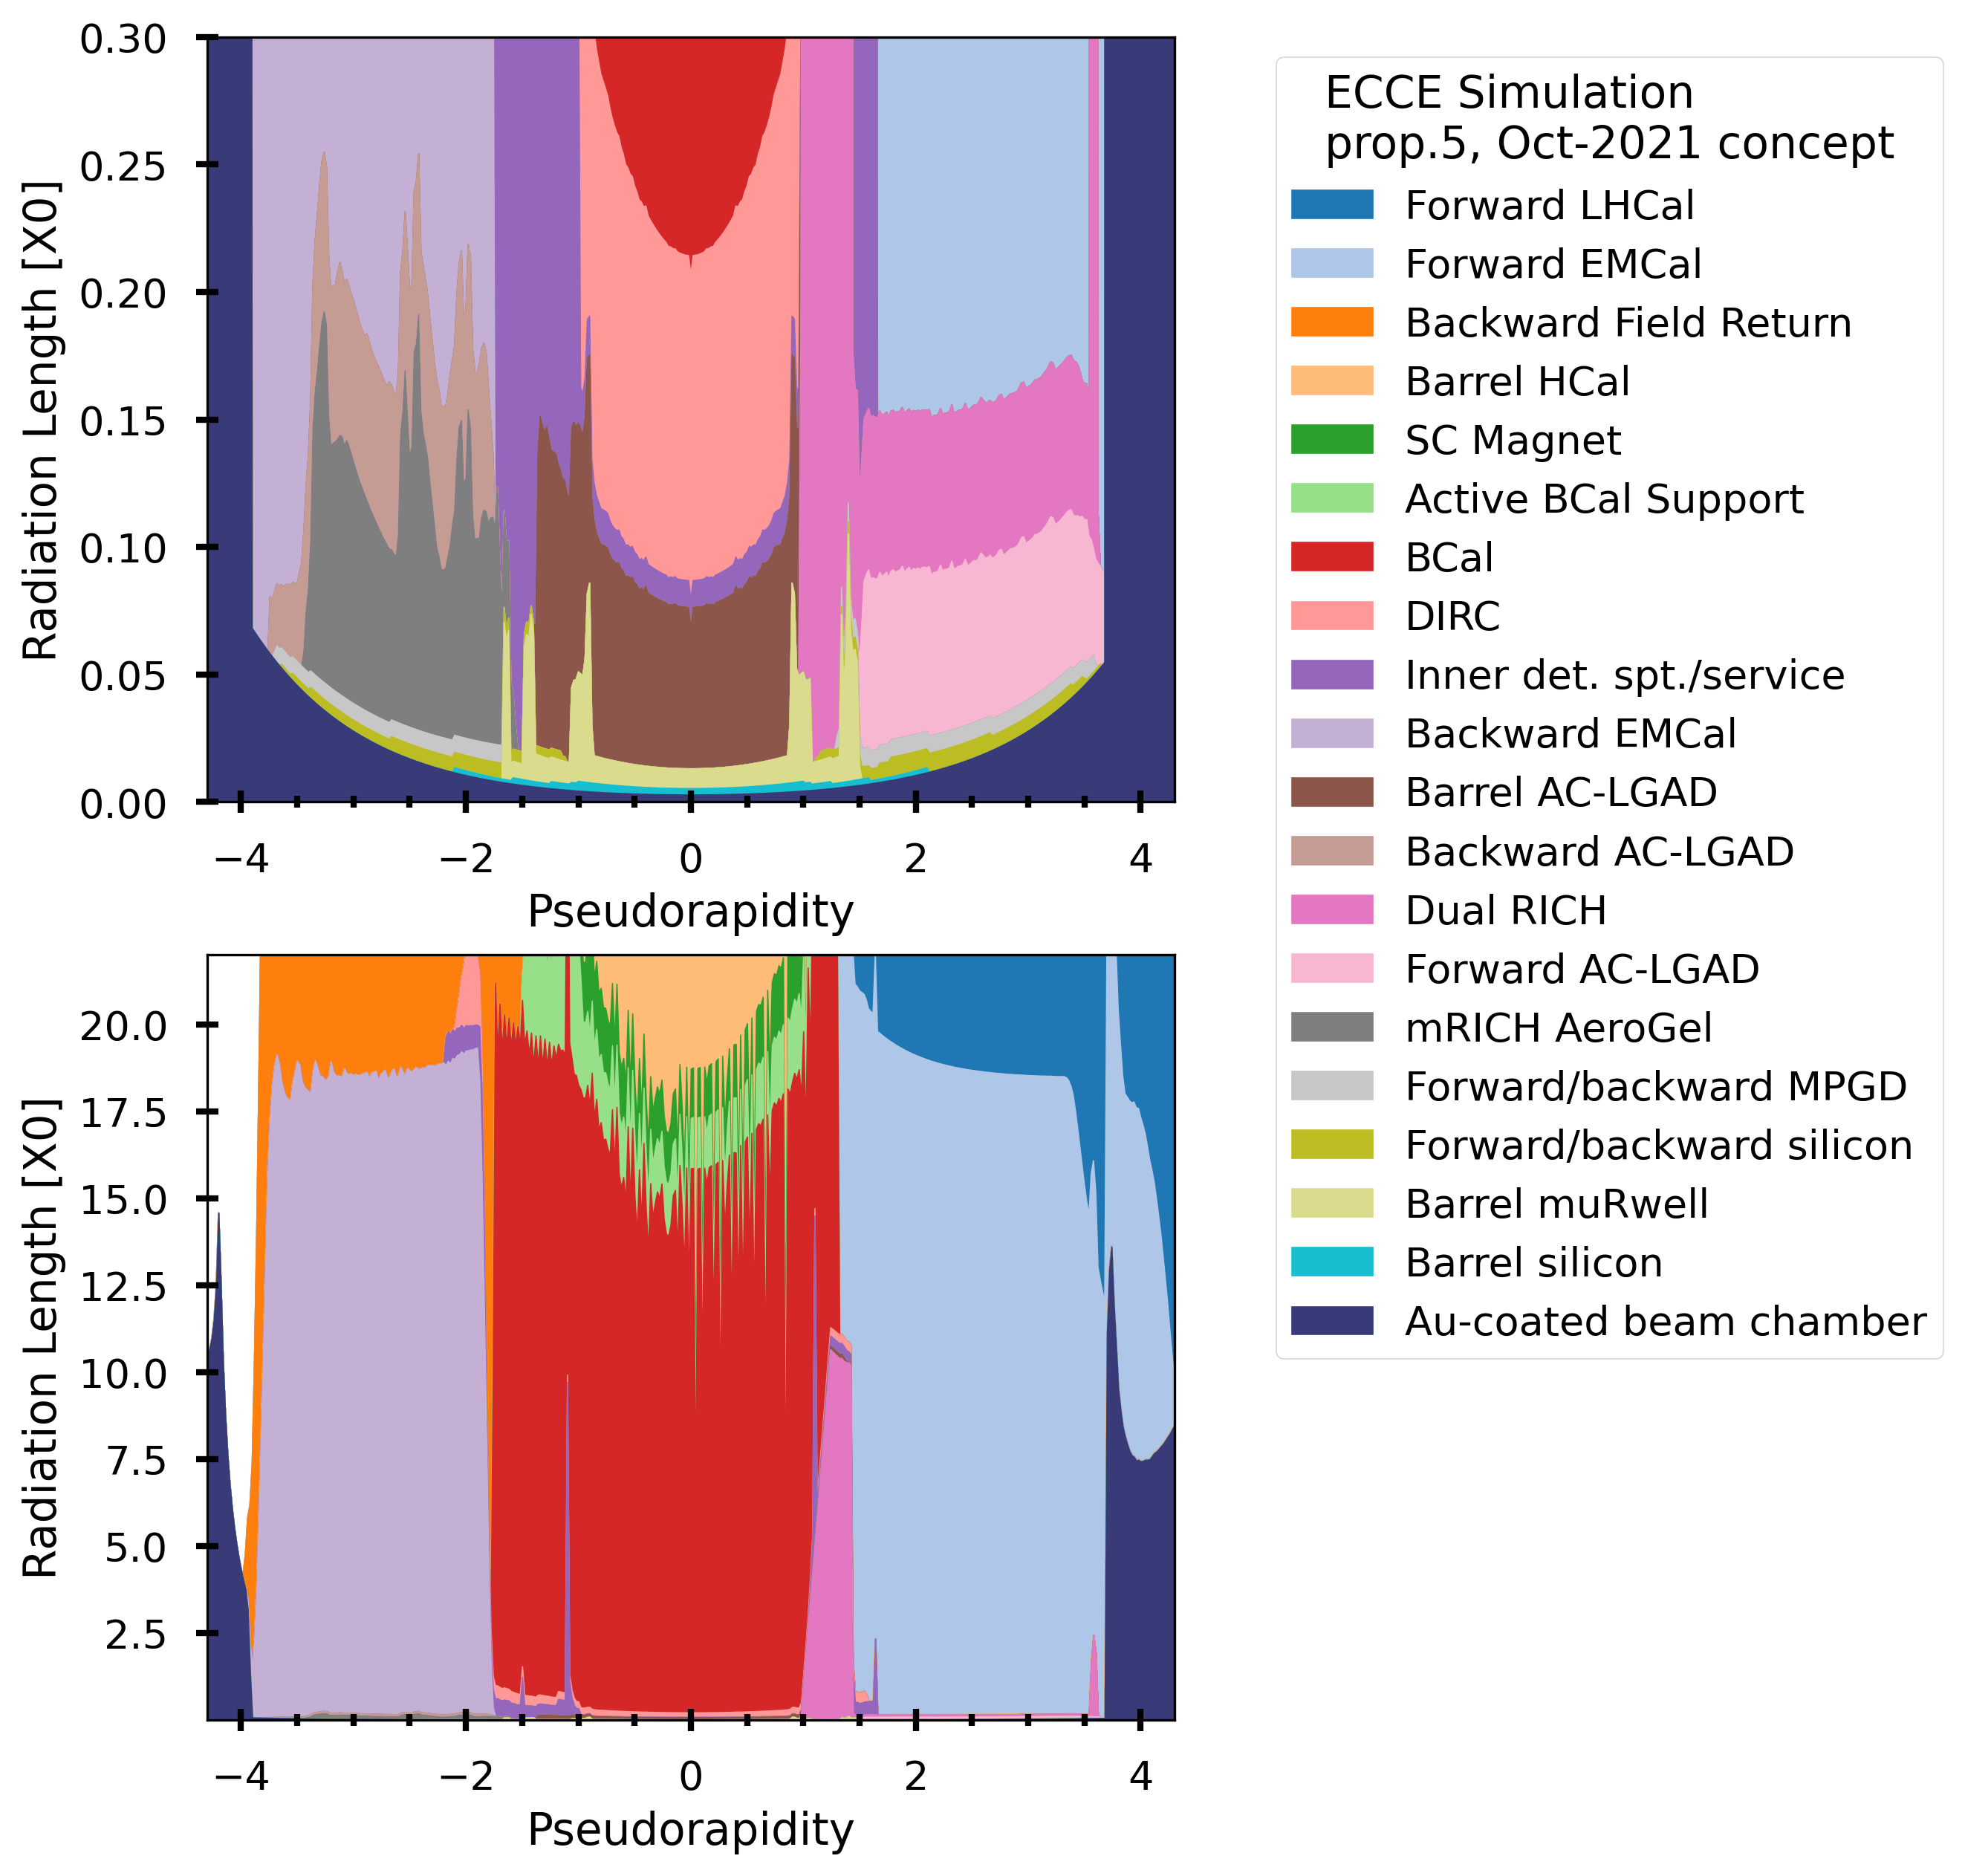

In [18]:
# fig= plt.figure(num=None, figsize=(8, 16), dpi=80, facecolor='w', edgecolor='k')
# ax = fig.add_subplot(1, 1, 1)  # create an axes object in the figure
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 10), dpi=300)


datasets = sorted(df.index.levels[0].unique().to_list(), reverse=True)

color_index = 0;

for dataset in datasets:
    
    x0_avg = df.loc[(dataset),:].groupby('Theta').x0.mean()
    etas = -np.log(np.tan( ((90-x0_avg.index.to_numpy())/180*np.pi)/2 ))
    polar_angles = 180- ( 90-x0_avg.index.to_numpy() )
    DataSetLable = DataSetLables[dataset]
    
    axs[0].fill_between( etas, 0, x0_avg.to_numpy(), label=DataSetLable, color = colors[color_index])
    
    axs[1].fill_between( etas, 0, x0_avg.to_numpy(), label=DataSetLable, color = colors[color_index])
   
    color_index = color_index +1
ax=axs[0]
    
# ax.set_title(f'Fun4All-EIC Simulation. Tracking and PID detectors\n{CautiousLabel}')
# ax.set_yscale('log')
ax.set_xlabel("Pseudorapidity")
ax.set_ylabel("Radiation Length [X0]")
ax.set_xlim([-4.3, 4.3]);
ax.set_ylim([0, 0.3]);

ax.tick_params(which='both',direction='inout');
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=7)
ax.tick_params(which='minor', length=4)

chartBox = ax.get_position()
ax.set_position([chartBox.x0, chartBox.y0, chartBox.width*0.7, chartBox.height])
ax.legend(loc='upper center', bbox_to_anchor=(1.45, 1), ncol=1,
         title = f'ECCE Simulation\n{CautiousLabel}',
         title_fontsize='x-large'
         )

ax=axs[1]

# ax.set_yscale('log')
ax.set_xlabel("Pseudorapidity")
ax.set_ylabel("Radiation Length [X0]")
ax.set_xlim([-4.3, 4.3]);
ax.set_ylim([1e-3, 22]);

ax.tick_params(which='both',direction='inout');
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=7)
ax.tick_params(which='minor', length=4)

chartBox = ax.get_position()
ax.set_position([chartBox.x0, chartBox.y0, chartBox.width*0.7, chartBox.height])
# ax.legend(loc='upper center', bbox_to_anchor=(1.45, 1), ncol=1,
#          title = f'Fun4All-EIC Simulation\nTracking and PID detectors\n{CautiousLabel}',
#          title_fontsize='x-large'
#          )

plt.savefig(os.path.join(f'{file_base}_Raditioan_Length_Log.pdf'), bbox_inches='tight')
plt.savefig(os.path.join(f'{file_base}_Raditioan_Length_Log.png'), bbox_inches='tight')

## Hadronic interaction length

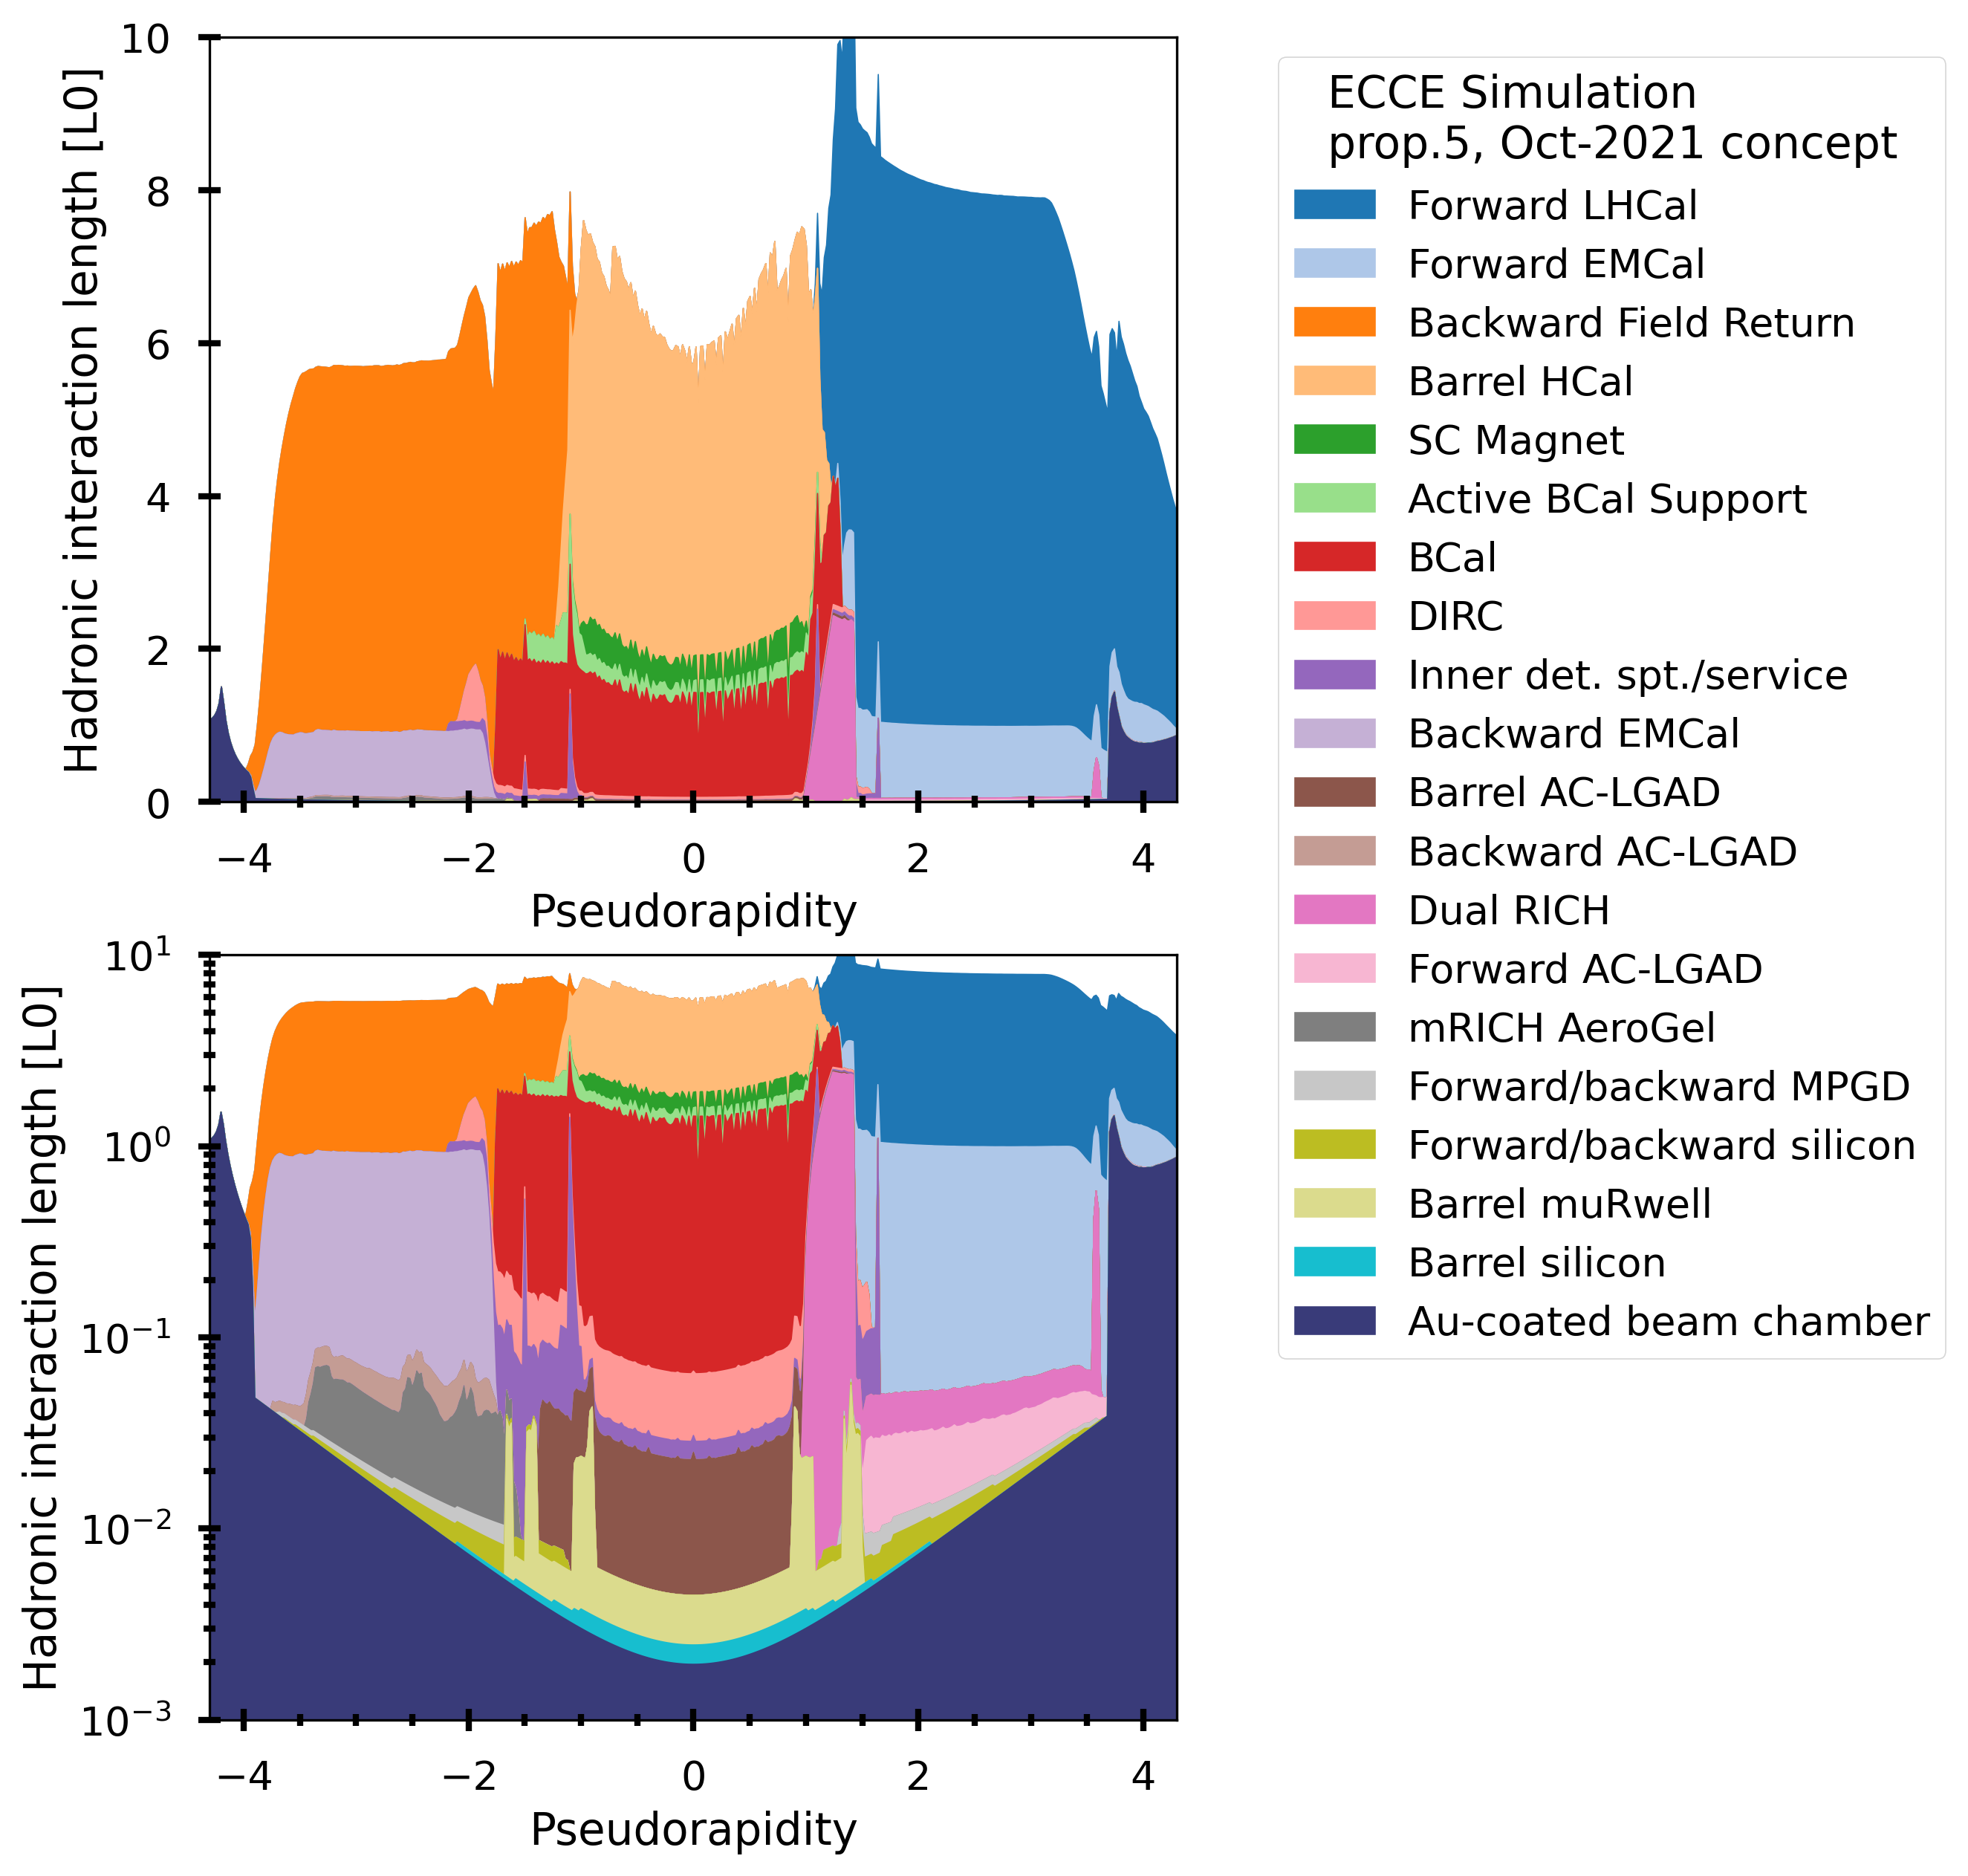

In [13]:
# fig= plt.figure(num=None, figsize=(8, 16), dpi=80, facecolor='w', edgecolor='k')
# ax = fig.add_subplot(1, 1, 1)  # create an axes object in the figure
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 10), dpi=300)


datasets = sorted(df.index.levels[0].unique().to_list(), reverse=True)

color_index = 0;

for dataset in datasets:
    
    lambda0_avg = df.loc[(dataset),:].groupby('Theta').lambda0.mean()
    etas = -np.log(np.tan( ((90-x0_avg.index.to_numpy())/180*np.pi)/2 ))
    polar_angles = 180- ( 90-x0_avg.index.to_numpy() )
    DataSetLable = DataSetLables[dataset]
    
    axs[0].fill_between( etas, 0, lambda0_avg.to_numpy(), label=DataSetLable, color = colors[color_index])
    
    axs[1].fill_between( etas, 0, lambda0_avg.to_numpy(), label=DataSetLable, color = colors[color_index])
   
    color_index = color_index +1
ax=axs[0]
    
# ax.set_title(f'Fun4All-EIC Simulation. Tracking and PID detectors\n{CautiousLabel}')
# ax.set_yscale('log')
ax.set_xlabel("Pseudorapidity")
ax.set_ylabel("Hadronic interaction length [L0]")
ax.set_xlim([-4.3, 4.3]);
ax.set_ylim([0, 10]);

ax.tick_params(which='both',direction='inout');
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=7)
ax.tick_params(which='minor', length=4)

chartBox = ax.get_position()
ax.set_position([chartBox.x0, chartBox.y0, chartBox.width*0.7, chartBox.height])
ax.legend(loc='upper center', bbox_to_anchor=(1.45, 1), ncol=1,
         title = f'ECCE Simulation\n{CautiousLabel}',
         title_fontsize='x-large'
         )

ax=axs[1]

ax.set_yscale('log')
ax.set_xlabel("Pseudorapidity")
ax.set_ylabel("Hadronic interaction length [L0]")
ax.set_xlim([-4.3, 4.3]);
ax.set_ylim([1e-3, 10]);

ax.tick_params(which='both',direction='inout');
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=7)
ax.tick_params(which='minor', length=4)

chartBox = ax.get_position()
ax.set_position([chartBox.x0, chartBox.y0, chartBox.width*0.7, chartBox.height])
# ax.legend(loc='upper center', bbox_to_anchor=(1.45, 1), ncol=1,
#          title = f'Fun4All-EIC Simulation\nTracking and PID detectors\n{CautiousLabel}',
#          title_fontsize='x-large'
#          )

plt.savefig(os.path.join(f'{file_base}_Hadronic_Interaction_Length_Log.pdf'), bbox_inches='tight')
plt.savefig(os.path.join(f'{file_base}_Hadronic_Interaction_Length_Log.png'), bbox_inches='tight')

In [10]:
len(datasets)

20